# Behavioral Incident Prediction Using Random Forest

This notebook demonstrates a proof-of-concept model for predicting behavioral incidents based on structured client compliance data. Using a synthetic dataset generated to reflect the distribution and properties of real-world data (with no PHI), I train a Random Forest classifier and evaluate performance.

The goal is to identify early warning signals and support proactive intervention strategies.


## Problem Statement

Can we use recent client activity data to predict the likelihood of a behavioral incident occurring the next day?

This model aims to support frontline staff in prioritizing high-risk cases by highlighting potential escalations in behavioral trends.


## Dataset Overview

The dataset includes 13 compliance-related features, 4 affect-related features, 17 strength-related features, and one feature for boundaries and one for predictability.  Boundaries and predictability are thought to behave differently than ordinary compliance and strength related features. Data has been generated to simulate daily entries per client.

I also include engineered features such as:

- Rolling 3-day mean compliance index
- Day-to-day delta in index score
- Incident flags for next-day or 3-day windows

Note: All data is synthetic and intended for demonstration purposes only.


## Class Imbalance

Behavioral incidents are rare events. To address class imbalance, I apply SMOTE (Synthetic Minority Over-sampling Technique) to upsample positive cases during training.

This helps prevent the model from defaulting to the majority (non-incident) class.


## Model: Random Forest Classifier

I train a Random Forest classifier with 100 trees and balanced class weights. Evaluation metrics include:

- Accuracy
- Precision / Recall
- Confusion Matrix
- Feature Importances

I also adjust the classification threshold to optimize for sensitivity (recall), as missing an incident is costlier than a false positive.




C:\Users\Will\AppData\Local\Temp\ipykernel_24328\3503602286.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-1).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_24328\3503602286.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-2).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_24328\3503602286.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obje

Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



c:\Users\Will\anaconda3\envs\AIResearchDoc\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Will\anaconda3\envs\AIResearchDoc\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Will\anaconda3\envs\AIResearchDoc\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

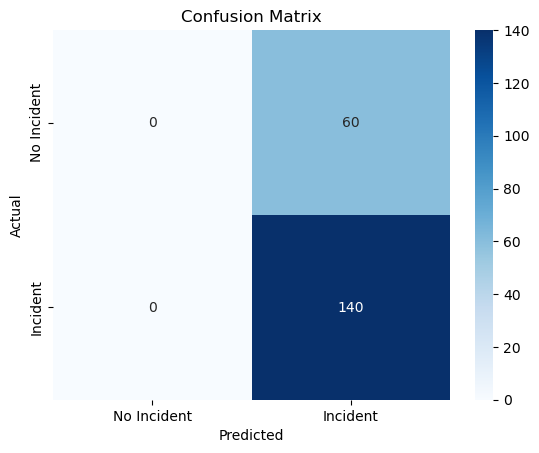

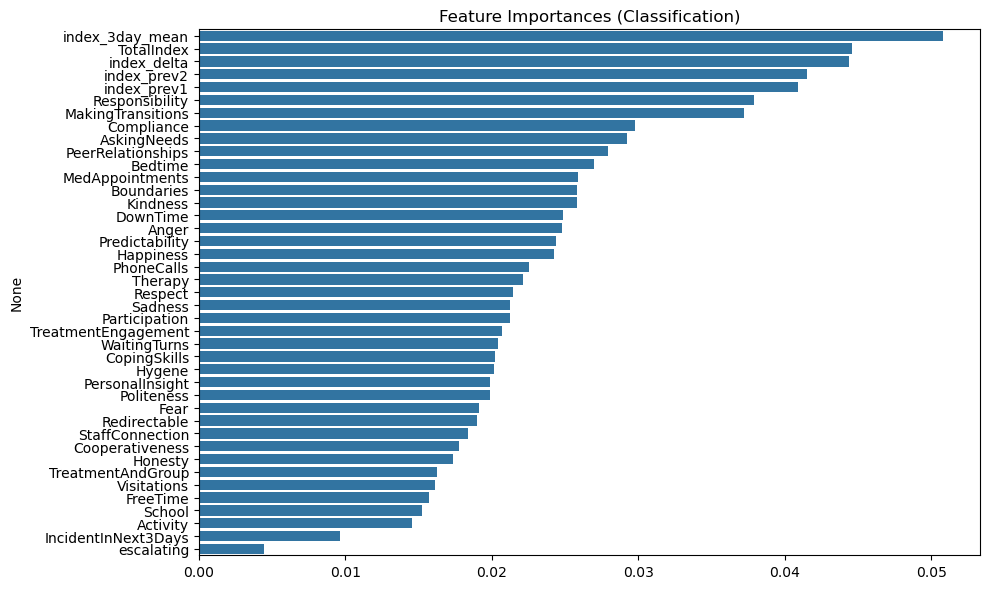

In [9]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load your dataset
file_path = Path.cwd().parent / "Data" / "fake_structured.csv"
df = pd.read_csv(file_path)  # replace with your actual dataset path
df = df.sort_values(by=['people_id', 'actual_date'])

df['index_prev1'] = df.groupby('people_id')['TotalIndex'].shift(1)
df['index_prev2'] = df.groupby('people_id')['TotalIndex'].shift(2)

df['index_3day_mean'] = df.groupby('people_id')['TotalIndex'].rolling(3).mean().reset_index(0, drop=True)
df['index_delta'] = df['TotalIndex'] - df['index_prev1']
df['escalating'] = (df['index_delta'] > 0) & (df['index_prev1'] > df['index_prev2'])
# Maybe try this as Target
incident = df['IncidentNextDay'].astype(bool)
df['IncidentInNext3Days'] = (
    incident.groupby(df['people_id']).shift(-1).fillna(False) |
    incident.groupby(df['people_id']).shift(-2).fillna(False) |
    incident.groupby(df['people_id']).shift(-3).fillna(False)
).astype(int)

# Assume target column is named 'index_score' or similar
df = df.iloc[:, 6:]
# target_col = 'IncidentNextDay'  # change this if yours is named differently
target_col = 'IncidentNextDay'
feature_cols = [col for col in df.columns if col != target_col]

# Split into features and target
X = df[feature_cols]
y = df[target_col]

smote = SMOTE(random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Keep alignment after drop
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Initialize and train model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # 'balanced' helps with class imbalance
clf.fit(X_train_bal, y_train_bal)

# Predict
# y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs > 0.2).astype(int)  # try 0.2 instead of 0.5

# Then evaluate y_pred_custom


# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Incident', 'Incident'], yticklabels=['No Incident', 'Incident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optional: Feature Importance
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances (Classification)")
plt.tight_layout()
plt.show()


## Conclusion

This model demonstrates the feasibility of early warning prediction for behavioral incidents using structured compliance data. While based on synthetic data, the results suggest potential for deployment in decision support tools.

Future improvements could include:

- Incorporating case narratives via NLP models
- Using RNNs or Transformers to model sequential data
- Calibrating thresholds with cost-sensitive metrics

This notebook is part of a larger research effort to improve safety and outcomes in youth treatment programs.
